# Importing all the Libraries

In [ ]:
import os
import warnings
import pickle
import requests
from IPython.display import display_html
! pip install wget
import wget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import cv2
from tqdm import tqdm
import random as rn
from random import shuffle
from zipfile import ZipFile
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV 

from keras.preprocessing.image import ImageDataGenerator
from keras import Model
from keras.models import Sequential
from keras.layers import ReLU, Dense, Dropout, Conv2D, MaxPool2D, Flatten, Activation, BatchNormalization,Input
from keras.layers import Conv2DTranspose, Concatenate, CenterCrop, concatenate
from tensorflow.keras.initializers import HeNormal
from keras.optimizers import Adam,SGD, Adagrad, Adadelta, RMSprop
from keras.utils import to_categorical

import tensorflow as tf
random_state=42
rn.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

Defaulting to user installation because normal site-packages is not writeable


# CNN Segmentation Model

# Loading resized images from the zip file to python variables

In [ ]:
from zipfile import ZipFile

with ZipFile("COP508_Dog_dataset.zip", 'r') as zipObj:
    zipObj.extractall()
path1="COP508_Dog_dataset/images"
path2="COP508_Dog_dataset/trimaps"

def create_dataset_PIL():
    
    img_data_array=[]
    map_data=[]
    for file in os.listdir(path1):
        image_p= os.path.join(path1, file)
        img_data_array.append(image_p)
    for file in os.listdir(path2):
        if "._" not in file and "png" in file:
            image_p= os.path.join(path2, file)
            map_data.append(image_p)     
    return img_data_array,map_data
img_data,map_data=create_dataset_PIL()
img_data.sort()
map_data.sort()
imgs=[]
masks=[]
for i in img_data:
    image = cv2.imread(i)
    image= cv2.resize(image,(96,96))
    image = np.array(image)
    imgs.append(image)
for i in map_data:
    image = Image.open(i)
    image= image.resize((96,96))
    image = np.array(image)
    masks.append(image)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


# Data Preprocessing

##### In this I normalise the data so that computations can give comparable results. So I divided the pixel value by 255 so that it ranges from 0 to 1 and subtracted 1 from masks so that the values among 0,1 and 2

In [ ]:
train_imgs = np.array(imgs)
train_masks = np.array(masks)

train_imgs=train_imgs/255
train_masks=train_masks-1
train_imgs.shape,train_masks.shape

((5190, 96, 96, 3), (5190, 96, 96))

# Data Visualisation

##### We pick 3 images and their masks randomly from train set and plot them next to each other

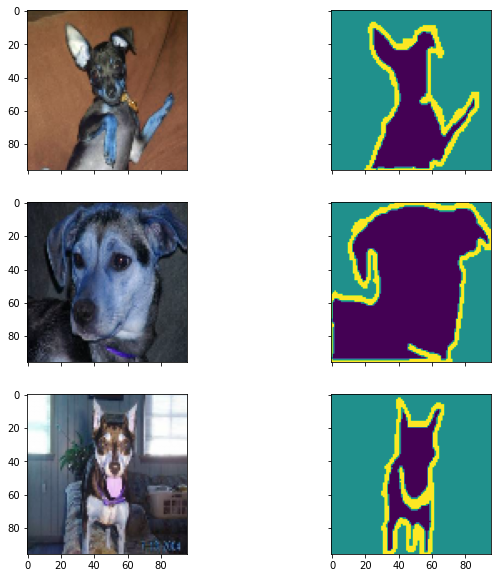

In [ ]:
n=np.random.randint(low=0, high=5000)

fx,ax = plt.subplots(nrows=3,ncols=2, sharex=True, sharey=True)
fx.set_size_inches(10,10)
ax[0,0].imshow(train_imgs[n])
ax[0,1].imshow(train_masks[n])
ax[1,0].imshow(train_imgs[n+1])
ax[1,1].imshow(train_masks[n+1])
ax[2,0].imshow(train_imgs[n+2])
ax[2,1].imshow(train_masks[n+2])

# Training and Testing split

##### We split the data in train and test sets and then I print the shapes of the sets

In [ ]:
train_imgs,test_imgs,train_masks,test_maps=train_test_split(train_imgs,train_masks,random_state=random_state)
train_imgs.shape,test_imgs.shape,train_masks.shape,train_masks.shape

((3892, 96, 96, 3), (1298, 96, 96, 3), (3892, 96, 96), (1298, 96, 96))

# Model version 1

##### In this architecture I used 5 blocks of (conv1,dropout,conv2,maxpool) in contracting path and 3 blovks of  (convtranspose,skip,conv1,dropout,conv2) in expanding path with output layer as one conv with 3 filters and activation as softmax. I decided to train the model for 10 epochs with a batch size of 100 and with 2 callbacks(save best model and adaptive learning rate for accuracy)

In [ ]:
inputs = Input((96, 96, 3))
s = inputs

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(s)
c1 = Dropout(0.1)(c1)
# c1 = BatchNormalization()(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c1)
p1 = MaxPool2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p1)
c2 = Dropout(0.1)(c2)
# c2 = BatchNormalization()(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c2)
p2 = MaxPool2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p2)
c3 = Dropout(0.2)(c3)
# c3 = BatchNormalization()(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c3)
p3 = MaxPool2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p3)
c4 = Dropout(0.2)(c4)
# c4 = BatchNormalization()(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c4)
p4 = MaxPool2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p4)
c5 = Dropout(0.3)(c5)
# c5 = BatchNormalization()(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c5)

#Expansive path
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c9)

outputs = Conv2D(3, (1, 1), activation='softmax')(c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_918 (Conv2D)            (None, 96, 96, 16)   448         ['input_43[0][0]']               
                                                                                                  
 dropout_386 (Dropout)          (None, 96, 96, 16)   0           ['conv2d_918[0][0]']             
                                                                                                  
 conv2d_919 (Conv2D)            (None, 96, 96, 16)   2320        ['dropout_386[0][0]']            
                                                                                           

 conv2d_transpose_209 (Conv2DTr  (None, 96, 96, 16)  2064        ['conv2d_933[0][0]']             
 anspose)                                                                                         
                                                                                                  
 concatenate_171 (Concatenate)  (None, 96, 96, 32)   0           ['conv2d_transpose_209[0][0]',   
                                                                  'conv2d_919[0][0]']             
                                                                                                  
 conv2d_934 (Conv2D)            (None, 96, 96, 16)   4624        ['concatenate_171[0][0]']        
                                                                                                  
 dropout_394 (Dropout)          (None, 96, 96, 16)   0           ['conv2d_934[0][0]']             
                                                                                                  
 conv2d_93

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("segmentation_cnn_model_v1.h5", save_best_only=True)
#Playing with LR when learning is stagnant
from keras.callbacks import ReduceLROnPlateau

red = ReduceLROnPlateau(monitor='accuracy',patience=3,verbose=1,factor=0.1)
history = model.fit(train_imgs,train_masks,batch_size=100,epochs=10,validation_split=0.1,callbacks=[checkpoint,red])

Epoch 1/10
36/36 [==============================] - 76s 2s/step - loss: 0.9111 - accuracy: 0.5997 - val_loss: 0.8273 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 2/10
36/36 [==============================] - 68s 2s/step - loss: 0.7406 - accuracy: 0.7081 - val_loss: 0.7436 - val_accuracy: 0.6888 - lr: 0.0010
Epoch 3/10
36/36 [==============================] - 68s 2s/step - loss: 0.6904 - accuracy: 0.7320 - val_loss: 0.6878 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 4/10
36/36 [==============================] - 69s 2s/step - loss: 0.6316 - accuracy: 0.7533 - val_loss: 0.6131 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 5/10
36/36 [==============================] - 67s 2s/step - loss: 0.5782 - accuracy: 0.7727 - val_loss: 0.5591 - val_accuracy: 0.7813 - lr: 0.0010
Epoch 6/10
36/36 [==============================] - 67s 2s/step - loss: 0.5369 - accuracy: 0.7886 - val_loss: 0.5407 - val_accuracy: 0.7885 - lr: 0.0010
Epoch 7/10
36/36 [==============================] - 68s 2s/step - loss: 0.5114 - a

# Result visualisation and comparision

##### Here I have plotted the accuracies and losses of train and validation data which show as drop that is not steady in terms of loss and an increase which is not steady as well. Also it shows a lot of overfitting towards the end where validation loss or accuracy is far from training.

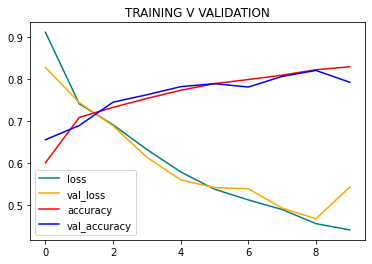

In [ ]:
plt.plot(history.history["loss"],color='teal',label='loass')
plt.plot(history.history["val_loss"],color='orange',label='val_loss')
plt.plot(history.history["accuracy"],color='red',label='accuracy')
plt.plot(history.history["val_accuracy"],color='blue',label='val_accuracy')
plt.title('TRAINING V VALIDATION')
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.show()

# Test Results

##### Shows a lot of overfitting

In [ ]:
model.evaluate(test_imgs,test_maps)

41/41 [==============================] - 3s 73ms/step - loss: 0.5595 - accuracy: 0.7885


[0.5595049262046814, 0.7885467410087585]

# Model version 2

##### I just decreased the batch size this time to 50 keeping the architecture as same to see the results

In [ ]:
inputs = Input((96, 96, 3))
s = inputs

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(s)
c1 = Dropout(0.1)(c1)
# c1 = BatchNormalization()(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c1)
p1 = MaxPool2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p1)
c2 = Dropout(0.1)(c2)
# c2 = BatchNormalization()(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c2)
p2 = MaxPool2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p2)
c3 = Dropout(0.2)(c3)
# c3 = BatchNormalization()(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c3)
p3 = MaxPool2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p3)
c4 = Dropout(0.2)(c4)
# c4 = BatchNormalization()(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c4)
p4 = MaxPool2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p4)
c5 = Dropout(0.3)(c5)
# c5 = BatchNormalization()(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c5)

#Expansive path
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c9)

outputs = Conv2D(3, (1, 1), activation='softmax')(c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_937 (Conv2D)            (None, 96, 96, 16)   448         ['input_44[0][0]']               
                                                                                                  
 dropout_395 (Dropout)          (None, 96, 96, 16)   0           ['conv2d_937[0][0]']             
                                                                                                  
 conv2d_938 (Conv2D)            (None, 96, 96, 16)   2320        ['dropout_395[0][0]']            
                                                                                           

 conv2d_transpose_213 (Conv2DTr  (None, 96, 96, 16)  2064        ['conv2d_952[0][0]']             
 anspose)                                                                                         
                                                                                                  
 concatenate_175 (Concatenate)  (None, 96, 96, 32)   0           ['conv2d_transpose_213[0][0]',   
                                                                  'conv2d_938[0][0]']             
                                                                                                  
 conv2d_953 (Conv2D)            (None, 96, 96, 16)   4624        ['concatenate_175[0][0]']        
                                                                                                  
 dropout_403 (Dropout)          (None, 96, 96, 16)   0           ['conv2d_953[0][0]']             
                                                                                                  
 conv2d_95

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("segmentation_cnn_model_v2.h5", save_best_only=True)
#Playing with LR when learning is stagnant
from keras.callbacks import ReduceLROnPlateau

red = ReduceLROnPlateau(monitor='accuracy',patience=3,verbose=1,factor=0.1)
history = model.fit(train_imgs,train_masks,batch_size=50,epochs=10,validation_split=0.1,callbacks=[checkpoint,red])

Epoch 1/10
71/71 [==============================] - 69s 946ms/step - loss: 0.8461 - accuracy: 0.6519 - val_loss: 0.7660 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 2/10
71/71 [==============================] - 68s 955ms/step - loss: 0.7042 - accuracy: 0.7164 - val_loss: 0.6477 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 3/10
71/71 [==============================] - 67s 945ms/step - loss: 0.6006 - accuracy: 0.7602 - val_loss: 0.5777 - val_accuracy: 0.7712 - lr: 0.0010
Epoch 4/10
71/71 [==============================] - 67s 945ms/step - loss: 0.5304 - accuracy: 0.7903 - val_loss: 0.5821 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 5/10
71/71 [==============================] - 67s 948ms/step - loss: 0.5034 - accuracy: 0.8023 - val_loss: 0.4855 - val_accuracy: 0.8120 - lr: 0.0010
Epoch 6/10
71/71 [==============================] - 67s 947ms/step - loss: 0.4580 - accuracy: 0.8205 - val_loss: 0.4540 - val_accuracy: 0.8206 - lr: 0.0010
Epoch 7/10
71/71 [==============================] - 68s 959ms/st

# Result visualisation and comparision

#### The results were better than earlier and showed a steady drop in loss and steady increase in accuracy but now the training and validation losses where not droping similarly which shoes some overfitting in the model.
##### There is a decrease in overfitting but it still needs some improvement

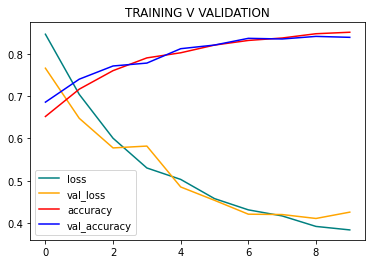

In [ ]:
plt.plot(history.history["loss"],color='teal',label='loass')
plt.plot(history.history["val_loss"],color='orange',label='val_loss')
plt.plot(history.history["accuracy"],color='red',label='accuracy')
plt.plot(history.history["val_accuracy"],color='blue',label='val_accuracy')
plt.title('TRAINING V VALIDATION')
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.show()

# Test Results

##### This shows some overfitting as the testing accuracy is less then training accuracy

In [ ]:
model.evaluate(test_imgs,test_maps)

41/41 [==============================] - 4s 87ms/step - loss: 0.4391 - accuracy: 0.8364


[0.43914517760276794, 0.8363869190216064]

# Model version 3

##### This time i added a batch normalisation layer after the dropout in contracting path to test if it reduces the overfitting and also reduced the batch size to 30

In [ ]:
inputs = Input((96, 96, 3))
s = inputs

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = BatchNormalization()(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c1)
p1 = MaxPool2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = BatchNormalization()(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c2)
p2 = MaxPool2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = BatchNormalization()(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c3)
p3 = MaxPool2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = BatchNormalization()(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c4)
p4 = MaxPool2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = BatchNormalization()(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c5)

#Expansive path
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=HeNormal(), padding='same')(c9)

outputs = Conv2D(3, (1, 1), activation='softmax')(c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_956 (Conv2D)            (None, 96, 96, 16)   448         ['input_45[0][0]']               
                                                                                                  
 dropout_404 (Dropout)          (None, 96, 96, 16)   0           ['conv2d_956[0][0]']             
                                                                                                  
 batch_normalization_200 (Batch  (None, 96, 96, 16)  64          ['dropout_404[0][0]']            
 Normalization)                                                                            

                                                                                                  
 conv2d_969 (Conv2D)            (None, 24, 24, 64)   36928       ['dropout_410[0][0]']            
                                                                                                  
 conv2d_transpose_216 (Conv2DTr  (None, 48, 48, 32)  8224        ['conv2d_969[0][0]']             
 anspose)                                                                                         
                                                                                                  
 concatenate_178 (Concatenate)  (None, 48, 48, 64)   0           ['conv2d_transpose_216[0][0]',   
                                                                  'conv2d_959[0][0]']             
                                                                                                  
 conv2d_970 (Conv2D)            (None, 48, 48, 32)   18464       ['concatenate_178[0][0]']        
          

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("segmentation_cnn_model_v3.h5", save_best_only=True)

In [ ]:
#Playing with LR when learning is stagnant
from keras.callbacks import ReduceLROnPlateau

red = ReduceLROnPlateau(monitor='accuracy',patience=3,verbose=1,factor=0.1)

In [ ]:
history = model.fit(train_imgs,train_masks,batch_size=30,epochs=10,validation_split=0.1,callbacks=[checkpoint,red])

Epoch 1/10
117/117 [==============================] - 73s 606ms/step - loss: 0.7319 - accuracy: 0.6945 - val_loss: 0.6928 - val_accuracy: 0.7261 - lr: 0.0010
Epoch 2/10
117/117 [==============================] - 70s 601ms/step - loss: 0.5574 - accuracy: 0.7798 - val_loss: 0.6505 - val_accuracy: 0.7542 - lr: 0.0010
Epoch 3/10
117/117 [==============================] - 70s 602ms/step - loss: 0.4793 - accuracy: 0.8107 - val_loss: 0.5327 - val_accuracy: 0.7921 - lr: 0.0010
Epoch 4/10
117/117 [==============================] - 70s 602ms/step - loss: 0.4387 - accuracy: 0.8289 - val_loss: 0.4928 - val_accuracy: 0.8121 - lr: 0.0010
Epoch 5/10
117/117 [==============================] - 72s 614ms/step - loss: 0.4188 - accuracy: 0.8375 - val_loss: 0.4271 - val_accuracy: 0.8324 - lr: 0.0010
Epoch 6/10
117/117 [==============================] - 70s 602ms/step - loss: 0.3952 - accuracy: 0.8466 - val_loss: 0.4125 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 7/10
117/117 [==============================] 

# Result visualisation and comparision

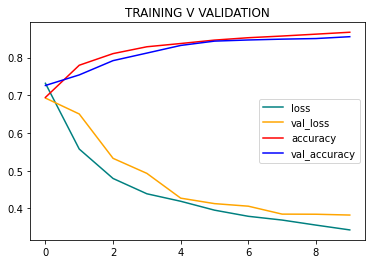

In [ ]:
plt.plot(history.history["loss"],color='teal',label='loass')
plt.plot(history.history["val_loss"],color='orange',label='val_loss')
plt.plot(history.history["accuracy"],color='red',label='accuracy')
plt.plot(history.history["val_accuracy"],color='blue',label='val_accuracy')
plt.title('TRAINING V VALIDATION')
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.show()

# Test Results

In [ ]:
model.evaluate(test_imgs,test_maps)

41/41 [==============================] - 4s 91ms/step - loss: 0.3920 - accuracy: 0.8521


[0.3919985890388489, 0.8520660996437073]

# Results on images

##### This was the best model as there was very less overfitting and the drop in loss and increase in accuracies for both training and validation set was smooth
### Test results for each model by randomly picking an image from testing data

1/1 [==============================] - 0s 148ms/step
model version 1
1/1 [==============================] - 0s 151ms/step
model version 2
1/1 [==============================] - 0s 176ms/step
model version 3


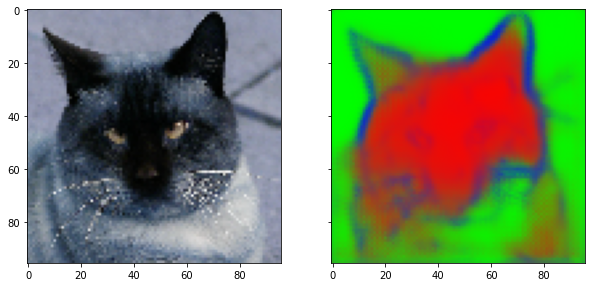

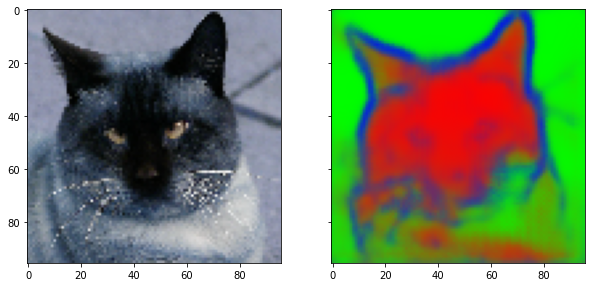

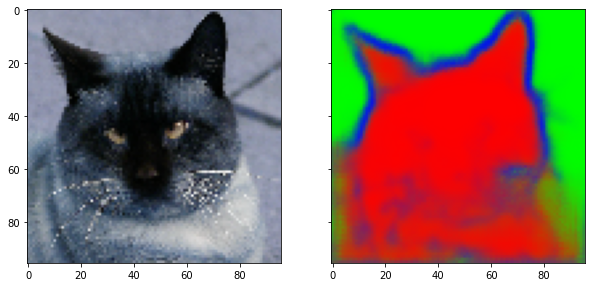

In [ ]:
model1 = tf.keras.models.load_model("segmentation_cnn_model_v1.h5")
model2 = tf.keras.models.load_model("segmentation_cnn_model_v2.h5")
model3 = tf.keras.models.load_model("segmentation_cnn_model_v3.h5")
test_imgs[0].shape
n=np.random.randint(low=0, high=1000)
pred = model1.predict(np.array([test_imgs[n],test_imgs[n+1],test_imgs[n+2]]))

print("model version 1")
fx,ax = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
fx.set_size_inches(10,10)
ax[0].imshow(test_imgs[n])

ax[1].imshow(pred[0])
pred = model2.predict(np.array([test_imgs[n],test_imgs[n+1],test_imgs[n+2]]))

print("model version 2")
fx,ax = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
fx.set_size_inches(10,10)
ax[0].imshow(test_imgs[n])

ax[1].imshow(pred[0])
pred = model3.predict(np.array([test_imgs[n],test_imgs[n+1],test_imgs[n+2]]))

print("model version 3")
fx,ax = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
fx.set_size_inches(10,10)
ax[0].imshow(test_imgs[n])

ax[1].imshow(pred[0])

# Testing on unknown image downloaded from the internet

1/1 [==============================] - 0s 142ms/step


Text(0.5, 1.0, 'mask')

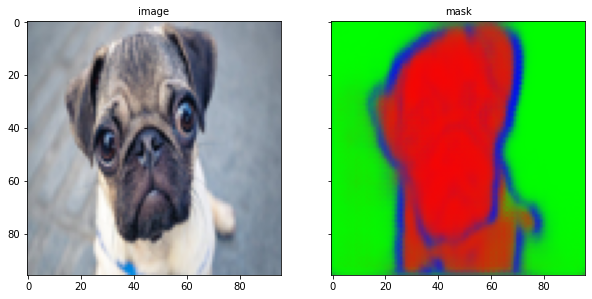

In [ ]:
from PIL import Image

model = tf.keras.models.load_model("segmentation_cnn_model.h5")
image = Image.open('dog.jpg')
image = image.resize((96,96))
a = np.array(image)
test = np.array([a])
test=test/255
result1 = model.predict(test)

fx,ax = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
fx.set_size_inches(10,10)
ax[0].imshow(a)
ax[0].set_title('image', fontsize=10)
ax[1].imshow(result1[0])
ax[1].set_title('mask', fontsize=10)

# Classificayion CNN Model

## Load Dataset

In [ ]:
def load_coursework_data():
    import wget
    path_to_check = os.path.join('', 'image_recognition_dataset.pth')
    if not os.path.exists(path_to_check):
        print("Cannot find the dataset on local !")
        print("Downloading the dataset from cloud, it may take several mintues.")
        url = 'https://www.dropbox.com/s/j05hyf667ikzu4s/image_recognition_dataset.pth?dl=1'
        filename = wget.download(url)
        data_path = os.path.join('', filename)
    else:
        print("Data founded on local {:s}".format(path_to_check))
        data_path = path_to_check
        
    data = pickle.load(open(data_path, 'rb'))
    train_imgs,train_labels,test_imgs,test_labels = data.values()
    return train_imgs,train_labels,test_imgs,test_labels

train_imgs,train_labels,test_imgs,test_labels = load_coursework_data()

Data founded on local image_recognition_dataset.pth


# Visualise Dataset

Total number of image classes : 8
Shape of training set (40000, 32, 32, 3)
Training image count:  40000
Test image count:  8000


([], [])

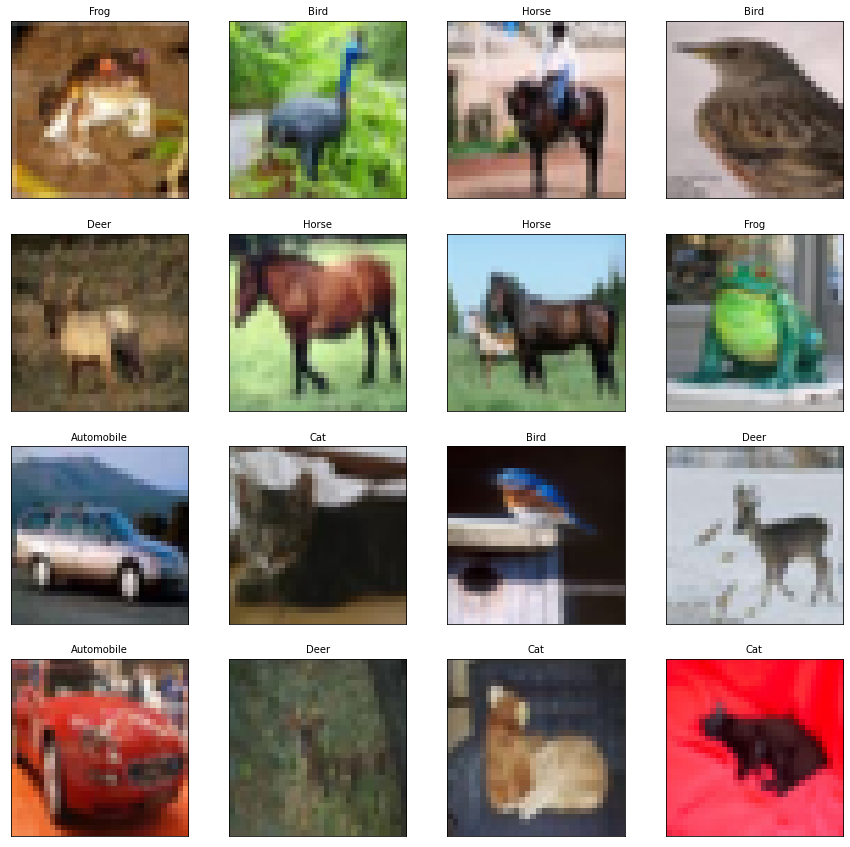

In [ ]:
# Load and plot training data to visualise

fx,a = plt.subplots(nrows=4,ncols=4, sharex=True, sharey=True)
fx.set_size_inches(15,15)
cls_train = len(np.unique(train_labels))
print("Total number of image classes : {:d}".format(cls_train))
print("Shape of training set", train_imgs.shape)

print("Training image count: ", train_imgs.shape[0])
print("Test image count: ", test_imgs.shape[0])
class_names=["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse"]
aj=-1
for i in range(0,16):
  ai=i%4
  if(ai==0):
    aj=aj+1
  a[ai,aj].imshow(train_imgs[i,:,:,:])
  a[ai,aj].set_title(class_names[int(train_labels[i])], fontsize=10)
plt.xticks([])
plt.yticks([])

# Data Preprocessing

In [ ]:
train_imgs = train_imgs/255
test_imgs=test_imgs/255

# Building validation set


In [ ]:
valid_train_imgs,valid_test_imgs,valid_train_labels,valid_test_labels=train_test_split(train_imgs[:4000],train_labels[:4000],random_state=random_state)
valid_train_imgs.shape,valid_train_labels.shape,valid_test_imgs.shape,valid_test_labels.shape

((3000, 32, 32, 3), (3000, 1), (1000, 32, 32, 3), (1000, 1))

# Some key decisions about the network which we need to try and test to arrive to a conclusion about what combination performs the best
*   No. of layers on the network
*   No. of Neurons/filters for each layer
*   Learning rate
*   Optimizer
*   Callback Strategy

##### I used this code for training multiple permutations and combinations of models
    #:
    def create_model(n,l):
      model = Sequential()
      model.add(Conv2D(filters = n,kernel_size=(3,3),padding='Same',activation='relu',input_shape=(32,32,3)))
      for i in range(1,l):
        model.add(Conv2D(filters = n,kernel_size=(3,3),padding='Same',activation='relu'))
      model.add(MaxPool2D(pool_size=(4,4)))
      model.add(Flatten())
      model.add(Dense(8,activation='relu'))
      model.add(Dense(8,activation='softmax'))
      return model

    acc_list = []
    val_acc_list=[]
    d={}
    for i in range(30,66,4):
        for j in range(4,6):
          model = create_model(i,j)
          print(model.summary())
          #Training the model
          model.compile(optimizer=Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
          history = model.fit(train_imgs,train_labels,batch_size=125,epochs=5,validation_data=(valid_train_imgs,valid_train_labels))
          acc_list.append(history.history['accuracy'][4])
          val_acc_list.append(history.history['val_accuracy'][4])
          d[str(i)+str(j)]=(history.history['accuracy'][4],history.history['val_accuracy'][4])
        plt.plot(np.array(range(len(acc_list))),acc_list)
        plt.plot(np.array(range(len(val_acc_list))),val_acc_list)
        plt.title('hyperparameter tunning')
        plt.ylabel('accuracy')
        plt.xlabel('no. of neurons/filters')
        plt.legend(['accuracy','val_accuracy'])
        plt.show()
    plt.plot(np.array(range(len(acc_list))),acc_list)
    plt.plot(np.array(range(len(val_acc_list))),val_acc_list)
    plt.title('hyperparameter tunning')
    plt.ylabel('accuracy')
    plt.xlabel('no. of neurons/filters')
    plt.legend(['accuracy','val_accuracy'])
    plt.show()

##### After running some test runs I could see some good results with number of filters in range 45-64 with 3-5 CNN layers, I ran some more tests to get the no. of neurons for layers 3-5.

# Model: "sequential_15"

```

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_67 (Conv2D)          (None, 32, 32, 58)        1624      
                                                                 
 conv2d_68 (Conv2D)          (None, 32, 32, 58)        30334     
                                                                 
 conv2d_69 (Conv2D)          (None, 32, 32, 58)        30334     
                                                                 
 conv2d_70 (Conv2D)          (None, 32, 32, 58)        30334     
                                                                 
 conv2d_71 (Conv2D)          (None, 32, 32, 58)        30334     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8, 8, 58)         0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 3712)              0         
                                                                 
 dense_30 (Dense)            (None, 8)                 29704     
                                                                 
 dense_31 (Dense)            (None, 8)                 72        
                                                                 
=================================================================
Total params: 152,736
Trainable params: 152,736
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
320/320 [==============================] - 147s 460ms/step - loss: 1.6348 - accuracy: 0.3880 - val_loss: 1.3544 - val_accuracy: 0.5013
Epoch 2/5
320/320 [==============================] - 147s 460ms/step - loss: 1.1750 - accuracy: 0.5733 - val_loss: 1.0724 - val_accuracy: 0.6187
Epoch 3/5
320/320 [==============================] - 146s 457ms/step - loss: 1.0058 - accuracy: 0.6365 - val_loss: 0.9404 - val_accuracy: 0.6647
Epoch 4/5
320/320 [==============================] - 147s 458ms/step - loss: 0.9058 - accuracy: 0.6742 - val_loss: 0.8071 - val_accuracy: 0.7107
Epoch 5/5
320/320 [==============================] - 145s 454ms/step - loss: 0.8232 - accuracy: 0.7054 - val_loss: 0.7205 - val_accuracy: 0.7480

```
##### Below are the list of accuracies for test number 15 "sequential_15" which shows 58 neurons in 5 CNN layers performed the best.

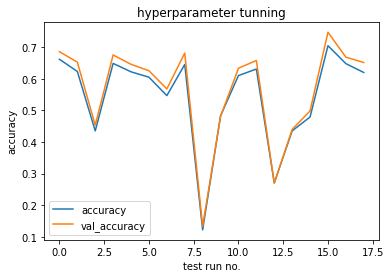

In [ ]:
acc_list=[0.6623250246047974,
 0.6237249970436096,
 0.43527498841285706,
 0.6492499709129333,
 0.6225749850273132,
 0.605525016784668,
 0.5471749901771545,
 0.645799994468689,
 0.12139999866485596,
 0.48315000534057617,
 0.6106250286102295,
 0.6314250230789185,
 0.2703250050544739,
 0.4354250133037567,
 0.4793500006198883,
 0.7053999900817871,
 0.6484500169754028,
 0.6204249858856201]

val_acc_list=[0.6863333582878113,
 0.653333306312561,
 0.4533333480358124,
 0.6759999990463257,
 0.6463333368301392,
 0.6259999871253967,
 0.5683333277702332,
 0.6819999814033508,
 0.13333334028720856,
 0.48100000619888306,
 0.6340000033378601,
 0.6583333611488342,
 0.2696666717529297,
 0.4399999976158142,
 0.4986666738986969,
 0.7480000257492065,
 0.6690000295639038,
 0.6520000100135803]

plt.plot(acc_list)
plt.plot(val_acc_list)
plt.title('hyperparameter tunning')
plt.ylabel('accuracy')
plt.xlabel('test run no.')
plt.legend(['accuracy','val_accuracy'])
plt.show()

# Model Version 1

In [ ]:
#model architecture
model = Sequential()

model.add(Conv2D(filters = 58,kernel_size=(3,3),padding='Same',activation='relu',input_shape=(32,32,3)))

model.add(Conv2D(filters = 58,kernel_size=(3,3),padding='Same',activation='relu'))

model.add(Conv2D(filters = 58,kernel_size=(3,3),padding='Same',activation='relu'))

model.add(Conv2D(filters = 58,kernel_size=(3,3),padding='Same',activation='relu'))

model.add(Conv2D(filters = 58,kernel_size=(3,3),padding='Same',activation='relu'))

model.add(MaxPool2D())

# model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(8,activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_975 (Conv2D)         (None, 32, 32, 58)        1624      
                                                                 
 conv2d_976 (Conv2D)         (None, 32, 32, 58)        30334     
                                                                 
 conv2d_977 (Conv2D)         (None, 32, 32, 58)        30334     
                                                                 
 conv2d_978 (Conv2D)         (None, 32, 32, 58)        30334     
                                                                 
 conv2d_979 (Conv2D)         (None, 32, 32, 58)        30334     
                                                                 
 max_pooling2d_189 (MaxPooli  (None, 16, 16, 58)       0         
 ng2D)                                                           
                                                      

# Training

In [ ]:
#Playing with LR when learning is stagnant
from keras.callbacks import ReduceLROnPlateau

red_lr = ReduceLROnPlateau(monitor='accuracy',patience=3,verbose=1,factor=0.1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cnn_model_best_v1.h5", save_best_only=True)
model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_imgs,train_labels,batch_size=50,epochs=10,validation_split=0.1,callbacks=[checkpoint_cb,red_lr])

Epoch 1/10
720/720 [==============================] - 128s 176ms/step - loss: 1.4846 - accuracy: 0.4415 - val_loss: 1.1997 - val_accuracy: 0.5605 - lr: 0.0010
Epoch 2/10
720/720 [==============================] - 130s 180ms/step - loss: 1.0588 - accuracy: 0.6128 - val_loss: 1.0046 - val_accuracy: 0.6385 - lr: 0.0010
Epoch 3/10
720/720 [==============================] - 129s 179ms/step - loss: 0.8718 - accuracy: 0.6858 - val_loss: 0.9077 - val_accuracy: 0.6848 - lr: 0.0010
Epoch 4/10
720/720 [==============================] - 129s 180ms/step - loss: 0.7419 - accuracy: 0.7345 - val_loss: 0.8817 - val_accuracy: 0.6920 - lr: 0.0010
Epoch 5/10
720/720 [==============================] - 129s 179ms/step - loss: 0.6298 - accuracy: 0.7744 - val_loss: 0.8874 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 6/10
720/720 [==============================] - 130s 181ms/step - loss: 0.5243 - accuracy: 0.8134 - val_loss: 0.9427 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 7/10
720/720 [==========================

# Result And Analysis

##### I recorded the accuracy and loss in training and validation data and plotted a graph to see the trend. It shows overfitting as traing and validation data is have different trend

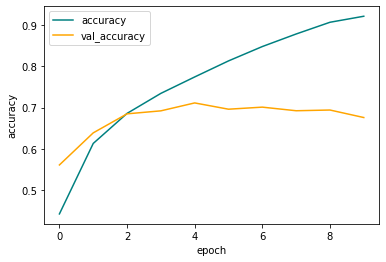

In [ ]:
plt.plot(history.history["accuracy"],color='teal',label='accuracy')
plt.plot(history.history["val_accuracy"],color='orange',label='val_accuracy')
plt.legend(['accuracy','val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Testing

In [ ]:
model.evaluate(test_imgs,test_labels)

250/250 [==============================] - 4s 16ms/step - loss: 1.4469 - accuracy: 0.6640


[1.4468902349472046, 0.6639999747276306]

# Model version 2 (Adding dropout layer)

In [ ]:
#model architecture
model = Sequential()

model.add(Conv2D(filters = 58,kernel_size=(3,3),padding='Same',activation='relu',input_shape=(32,32,3)))

model.add(Conv2D(filters = 58,kernel_size=(3,3),padding='Same',activation='relu'))

model.add(Conv2D(filters = 58,kernel_size=(3,3),padding='Same',activation='relu'))

model.add(Conv2D(filters = 58,kernel_size=(3,3),padding='Same',activation='relu'))

model.add(Conv2D(filters = 58,kernel_size=(3,3),padding='Same',activation='relu'))

model.add(MaxPool2D())

model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(8,activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_980 (Conv2D)         (None, 32, 32, 58)        1624      
                                                                 
 conv2d_981 (Conv2D)         (None, 32, 32, 58)        30334     
                                                                 
 conv2d_982 (Conv2D)         (None, 32, 32, 58)        30334     
                                                                 
 conv2d_983 (Conv2D)         (None, 32, 32, 58)        30334     
                                                                 
 conv2d_984 (Conv2D)         (None, 32, 32, 58)        30334     
                                                                 
 max_pooling2d_190 (MaxPooli  (None, 16, 16, 58)       0         
 ng2D)                                                           
                                                      

In [ ]:
from keras.callbacks import ReduceLROnPlateau

red_lr = ReduceLROnPlateau(monitor='accuracy',patience=3,verbose=1,factor=0.1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cnn_model_best_v2.h5", save_best_only=True)
model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_imgs,train_labels,batch_size=30,epochs=10,validation_split=0.1,callbacks=[checkpoint_cb,red_lr])

Epoch 1/10
1200/1200 [==============================] - 133s 111ms/step - loss: 1.5300 - accuracy: 0.4290 - val_loss: 1.2081 - val_accuracy: 0.5705 - lr: 0.0010
Epoch 2/10
1200/1200 [==============================] - 135s 113ms/step - loss: 1.1478 - accuracy: 0.5818 - val_loss: 0.9956 - val_accuracy: 0.6363 - lr: 0.0010
Epoch 3/10
1200/1200 [==============================] - 132s 110ms/step - loss: 0.9937 - accuracy: 0.6407 - val_loss: 0.9445 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 4/10
1200/1200 [==============================] - 133s 111ms/step - loss: 0.8887 - accuracy: 0.6779 - val_loss: 0.9135 - val_accuracy: 0.6823 - lr: 0.0010
Epoch 5/10
1200/1200 [==============================] - 132s 110ms/step - loss: 0.8220 - accuracy: 0.7037 - val_loss: 0.8372 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 6/10
1200/1200 [==============================] - 132s 110ms/step - loss: 0.7650 - accuracy: 0.7250 - val_loss: 0.8783 - val_accuracy: 0.6935 - lr: 0.0010
Epoch 7/10
1200/1200 [============

# Testing

In [ ]:
model.evaluate(test_imgs,test_labels)

250/250 [==============================] - 4s 16ms/step - loss: 0.8228 - accuracy: 0.7181


[0.8228397965431213, 0.7181249856948853]

# Result and analysis

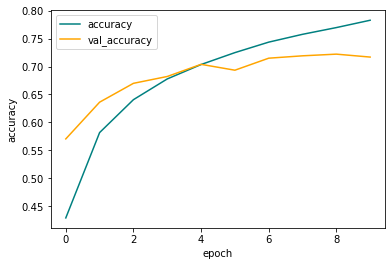

In [ ]:
plt.plot(history.history["accuracy"],color='teal',label='accuracy')
plt.plot(history.history["val_accuracy"],color='orange',label='val_accuracy')
plt.legend(['accuracy','val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Testing on unknown data

In [ ]:
model1 = tf.keras.models.load_model("my_cnn_model_best_v2.h5")

1/1 [==============================] - 0s 12ms/step


Text(0.5, 1.0, 'Automobile')

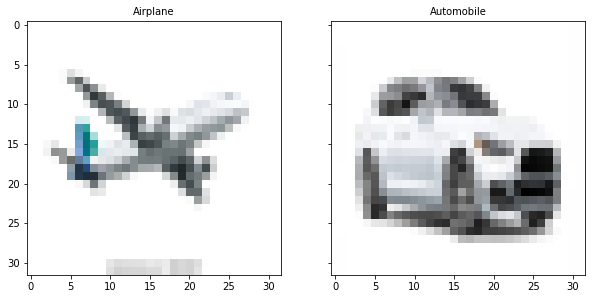

In [ ]:
from PIL import Image

image = Image.open('cat.jpg')
image = image.resize((32,32))
a = np.array(image)
a.shape
test = np.array([a])
result1 = model.predict(test)

image = Image.open('car.jpg')
image = image.resize((32,32))
b = np.array(image)
test = np.array([b])
result2 = model.predict(test)

fx,ax = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
fx.set_size_inches(10,10)
ax[0].imshow(np.array(a))
ax[0].set_title(class_names[result1.argmax()], fontsize=10)
ax[1].imshow(np.array(b))
ax[1].set_title(class_names[result2.argmax()], fontsize=10)